In [40]:
# -- Base -- #
import os
import joblib
import logging
import time
import re
import io
from datetime import datetime
from tqdm import tqdm
import ipdb
from copy import deepcopy
from dataclasses import dataclass
import sys
import json
from pathlib import Path
import yaml
import shutil

# -- Metrics -- #
import numpy as np
import pandas as pd
import sqlite3 as sql
import tensorboard

# -- Tensorflow -- #
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

# -- Misc Models -- #
import drain3
from gensim.models.phrases import Phrases
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import SVC

# -- Dash -- #
import dash
import dash_table
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.io as pio
import plotly.express as px
from dash import no_update
from flask_caching import Cache

/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [5]:
logging.basicConfig(format='%(asctime)s %(levelname)s | %(message)s',
                    level=logging.INFO,
                    stream=sys.stdout)
logger = logging.getLogger(__name__)

In [9]:
root = '/home/' + os.environ['USER']
data_path = '/data/'

In [10]:
train_frame = pd.read_csv(root + data_path + 'train.csv')

In [12]:
train_frame.head(n=25)

id url_legal license  \
0   c12129c31       NaN     NaN   
1   85aa80a4c       NaN     NaN   
2   b69ac6792       NaN     NaN   
3   dd1000b26       NaN     NaN   
4   37c1b32fb       NaN     NaN   
5   f9bf357fe       NaN     NaN   
6   eaf8e7355       NaN     NaN   
7   0a43a07f1       NaN     NaN   
8   f7eff7419       NaN     NaN   
9   d96e6dbcd       NaN     NaN   
10  c57b50918       NaN     NaN   
11  8d8a2667f       NaN     NaN   
12  a0d4cd896       NaN     NaN   
13  0963b8cf9       NaN     NaN   
14  587502a70       NaN     NaN   
15  af79954c5       NaN     NaN   
16  7656dea91       NaN     NaN   
17  60ecc9777       NaN     NaN   
18  057f69731       NaN     NaN   
19  5e7c0b55b       NaN     NaN   
20  a9ebe5d33       NaN     NaN   
21  47e98a5c8       NaN     NaN   
22  7285ba024       NaN     NaN   
23  66f0a9ff1       NaN     NaN   
24  e4f3550b2       NaN     NaN   

                                              excerpt    target  \
0   When the young people returned to the ballroom... -0.340259   
1   All through dinner time, Mrs. Fayre was somewh... -0.315372   
2   As Roger had predicted, the snow departed as q... -0.580118   
3   And outside before the palace a great garden w... -1.054013   
4   Once upon a time there were Three Bears who li...  0.247197   
5   Hal and Chester found ample time to take an in... -0.861809   
6   Hal Paine and Chester Crawford were typical Am... -1.759061   
7   On the twenty-second of February, 1916, an aut... -0.952325   
8   The boys left the capitol and made their way d... -0.371641   
9   One day he had gone beyond any point which he ... -1.238432   
10  It was believed by the principal men of Virgin... -3.081337   
11  This Pedrarias was seventy-two years old. He w... -2.145248   
12  The Emperor walked nervously up and down the l... -1.400318   
13  The clock in a nearby church struck the hour o... -0.495299   
14  Aunt Abigail was gone, Eleanor was gone. The r...  0.245806   
15  So off went Lionel to be made a King. He had n... -0.188186   
16  Her name was Simpkins, and her cottage was jus... -1.286039   
17  The children had explored the gardens and the ... -0.617733   
18  It was a wet day, so none of the plans for see... -1.126248   
19  Father had been away in the country for three ... -1.009999   
20  Then the man took off his hat and walked away,...  0.281178   
21  At that moment the queen came out through the ...  0.278203   
22  Were you ever on the coast of Maine? If so, yo... -1.566220   
23  If nature afflicts in one direction she freque... -2.386485   
24  One beautiful misummer night in 18— a large, h... -1.483887   

    standard_error  
0         0.464009  
1         0.480805  
2         0.476676  
3         0.450007  
4         0.510845  
5         0.480936  
6         0.476507  
7         0.498116  
8         0.463710  
9         0.465900  
10        0.553260  
11        0.518351  
12        0.494799  
13        0.471694  
14        0.491793  
15        0.481518  
16        0.470564  
17        0.496645  
18        0.477028  
19        0.496148  
20        0.510595  
21        0.484045  
22        0.485318  
23        0.526079  
24        0.476219

2021-05-24 22:46:16,388 INFO | NumExpr defaulting to 4 threads.


<AxesSubplot:xlabel='target', ylabel='Count'>

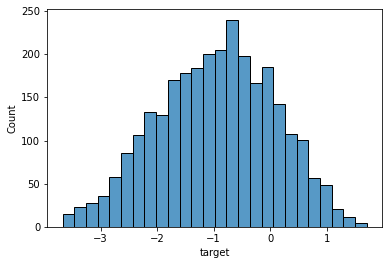

In [15]:
sns.histplot(train_frame['target'])

<AxesSubplot:xlabel='standard_error', ylabel='Count'>

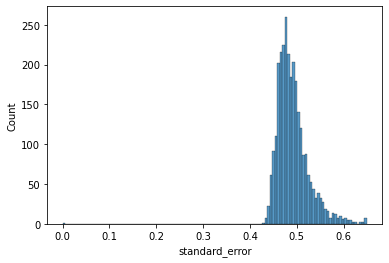

In [16]:
sns.histplot(train_frame['standard_error'])

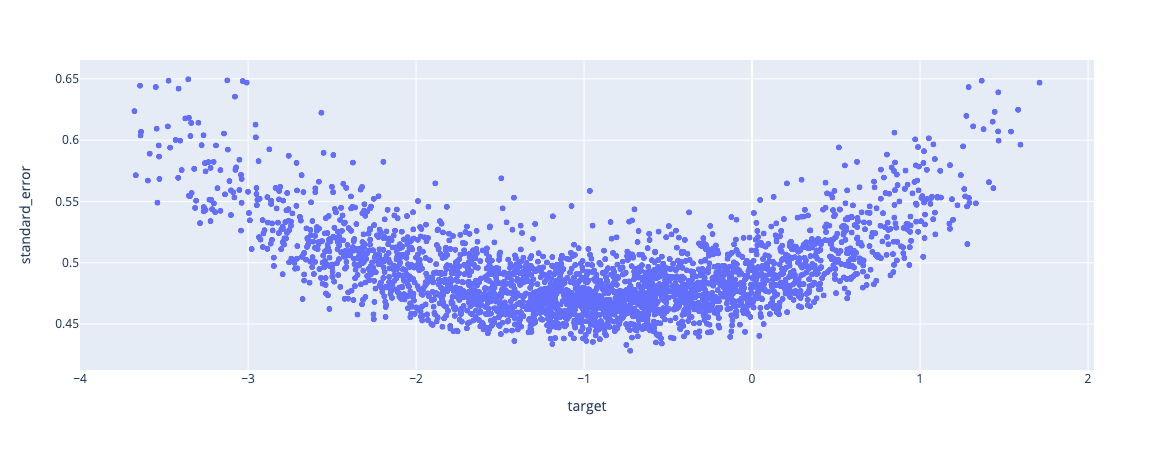

In [26]:
fig = px.scatter(train_frame[train_frame['standard_error']!=0], x="target", y="standard_error", hover_data=['id','excerpt'])
fig.show()

In [30]:
len(train_frame["excerpt"].str.lower().str.split(" ").apply(pd.Series).stack().unique())

53607

In [27]:
!pip install tokenizers

     |████████████████████████████████| 3.3 MB 4.2 MB/s eta 0:00:01


In [32]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders

In [35]:
tokenizer = Tokenizer(WordPiece(unk_token='[UNK]'))

tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])

tokenizer.pre_tokenizer = Whitespace()

tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

trainer = WordPieceTrainer(
    vocab_size=60000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[MASK]", "[PAD]"], 
)

tokenizer.enable_padding(length=512)
tokenizer.enable_truncation(512)

tokenizer.decoder = decoders.WordPiece()

In [52]:
data_itr = iter(train_frame['excerpt'])
tokenizer.train_from_iterator(data_itr, trainer)

In [77]:
def save_model(model, path):
#     if not os.path.exists(path):
#         return

    if os.path.isfile(path):
        os.remove(path)
#     elif os.path.isdir(path):
#         shutil.rmtree(path)
#         return

    joblib.dump(model, path)

In [78]:
def set_attributes(self, config: dict):
    try:
        config = config[self.__class__.__name__]
    except Exception as e:
        logger.warning(e)
        logger.warning('No configuration found for ' +
                       self.__class__.__name__)

    for attr in config.keys():
        setattr(self, attr, config[attr])

        
@dataclass
class PreprocessingGlobalConfig:
    embed_size: int = 512
    max_vocab_size: int = 2000
    buffer_size: int = 10000
    global_training: bool = True
    path: str = '/results/'

    def load(self, config):
        set_attributes(self, config)

        
@dataclass
class NegativeSkipgramLayerConfig:
    window_size: int = 2
    num_neg_sampling: int = 10
    load_model: bool = True
    save_model: bool = False
    training: bool = True

    def load(self, config):
        set_attributes(self, config)


@dataclass
class W2VLayerConfig:
    epochs: int = 25
    batch_size: int = 2048
    load_model: bool = True
    save_model: bool = False
    training: bool = True
    model_name: bool = 'word2vec'

    def load(self, config):
        set_attributes(self, config)


class PreprocessingPipelineConfig:
    def __init__(self):
        self.PreprocessingGlobalConfig = PreprocessingGlobalConfig()
        self.NegativeSkipgrameLayerConfig = NegativeSkipgramLayerConfig()
        self.W2VLayerConfig = W2VLayerConfig()

    def load(self, path):
        try:
            with open(path) as f:
                preprocessing_config = yaml.load(f, Loader=yaml.FullLoader)
        except FileNotFoundError as e:
            logger.warning(e)
            return None

        self.PreprocessingGlobalConfig.load(preprocessing_config)
        self.NegativeSkipgrameLayerConfig.load(preprocessing_config)
        self.W2VLayerConfig.load(preprocessing_config)

In [79]:
@dataclass
class NSLBundle:
    targets: list
    contexts: list
    labels: list


class NegativeSkipgramLayer(tf.keras.layers.Layer):

    def __init__(self,
                 config: NegativeSkipgramLayerConfig,
                 global_config: PreprocessingGlobalConfig):

        super(NegativeSkipgramLayer, self).__init__()
        self.vocab_size = 0
        self.vectorized_logs, self.corpus = [], []
        self.targets, self.contexts, self.labels = [], [], []
        self.vocab = {}
        self.embedding_dim = global_config.embed_size
        self.window_size = config.window_size
        self.load_data = config.load_model
        self.save_data = config.save_model
        self.num_neg_sampling = global_config.num_neg_sampling
        self.path = global_config.path

    def collect_vocabulary(self):
        encoded_values = tokenizer.encode_batch(self.corpus)
        self.vectorized_logs = [log.ids for log in encoded_values]
        self.vocab = tokenizer.get_vocab()

    def find_word_context(self):

        # Build the sampling table for vocab_size tokens.
        sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(len(self.vocab))

        for sequence in tqdm(self.vectorized_logs, position=0, leave=True):

            positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
                sequence,
                vocabulary_size=len(self.vocab),
                sampling_table=sampling_table,
                window_size=self.window_size,
                negative_samples=0)

            for target_word, context_word in positive_skip_grams:
                context_class = tf.expand_dims(
                    tf.constant([context_word], dtype='int64'), 1)

                negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                    true_classes=context_class,
                    num_true=1,
                    num_sampled=self.num_neg_sampling,
                    unique=True,
                    range_max=len(self.vocab),
                    seed=42,
                    name="negative_sampling")

                negative_sampling_candidates = tf.expand_dims(
                    negative_sampling_candidates, 1)

                context = tf.concat([context_class, negative_sampling_candidates], 0)
                label = tf.constant([1] + [0] * self.num_neg_sampling, dtype='int64')

                self.targets.append(target_word)
                self.contexts.append(context)
                self.labels.append(label)

    def call(self, corpus, training):
        if self.load_data:
            try:
                self.targets = joblib.load(root + self.path + 'targets.joblib')
                self.contexts = joblib.load(root + self.path + 'contexts.joblib')
                self.labels = joblib.load(root + self.path + 'labels.joblib')
            except Exception as e:
                print(e)
        else:
            self.corpus = corpus
            self.collect_vocabulary()
            self.find_word_context()

            if self.save_data:
                save_model(self.targets,
                           root + self.path + 'targets.joblib')
                save_model(self.contexts,
                           root + self.path + 'contexts.joblib')
                save_model(self.labels,
                           root + self.path + 'labels.joblib')

        return NSLBundle(self.targets, self.contexts, self.labels)

In [80]:
class Word2VecEmbeddingLayer(tf.keras.layers.Layer):

    def __init__(self,
                 config: W2VLayerConfig,
                 global_config: PreprocessingGlobalConfig):

        super(Word2VecEmbeddingLayer, self).__init__()
        self.embeddings = {}
        self.embedding_dim = global_config.embed_size
        self.buffer_size = global_config.buffer_size
        self.num_neg_sampling = global_config.num_neg_sampling
        self.load_model = config.load_model
        self.save_model = config.save_model
        self.batch_size = config.batch_size
        self.epochs = config.epochs
        self.Optimizer = tf.keras.optimizers.Adam()
        self.path = global_config.path
        self.model_name = config.model_name

        if self.load_model:
            self.Word2Vec = load_model(SOURCE + self.path + self.model_name)
        else:
            self.Word2Vec = None

    def call(self, in_bundle, training):

        targets = in_bundle.targets
        contexts = in_bundle.contexts
        labels = in_bundle.labels

        if self.Word2Vec is None:
            self.Word2Vec = Word2Vec(len(tokenizer.get_vocab().keys()), self.embedding_dim, self.num_neg_sampling)
            self.Word2Vec.compile(
                optimizer=self.Optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

        dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
        dataset = dataset.shuffle(self.buffer_size).batch(self.batch_size, drop_remainder=True)
        dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

        if training:
            self.Word2Vec.fit(dataset, epochs=self.epochs)

        weights = self.Word2Vec.get_layer('w2v_embedding').get_weights()[0]

        for word in vocab.items():
            self.embeddings.update({
                word[1]: weights[word[0]]
                })

        if self.save_model:
            if os.path.exists(SOURCE + self.path + self.model_name):
                shutil.rmtree(SOURCE + self.path + self.model_name)
            self.Word2Vec.save(SOURCE + self.path + self.model_name)
            out_v = io.open(SOURCE + self.path + 'vectors.tsv', 'w', encoding='utf-8')
            out_m = io.open(SOURCE + self.path + 'metadata.tsv', 'w', encoding='utf-8')

            for index, word in enumerate(tokenizer.get_vocab().values()):
                if index == 0:
                    continue  # skip 0, it's padding.
                vec = weights[index]
                out_v.write('\t'.join([str(x) for x in vec]) + "\n")
                out_m.write(word + "\n")
            out_v.close()
            out_m.close()

        self.Word2Vec.summary()
        return self.embeddings

In [81]:
class Word2Vec(tf.keras.models.Model):

    def __init__(self, vocab_size, embedding_dim, num_neg_sampling):
        super(Word2Vec, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_dim,
            input_length=1, # input length 1 since we are focusing on one token
            name="w2v_embedding")

        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_dim,
            input_length=num_neg_sampling + 1) # window size for contextual 
            # reasoning behind the sample token
        self.dots = tf.keras.layers.Dot(axes=(3, 2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

In [82]:
class W2V_Pipeline(tf.keras.Model):
    def __init__(self, config: PreprocessingPipelineConfig):
        super(W2V_Pipeline, self).__init__()

        self.NSL = NegativeSkipgramLayer(config.NegativeSkipgrameLayerConfig,
                                         config.PreprocessingGlobalConfig)

        self.W2V = Word2VecEmbeddingLayer(config.W2VLayerConfig,
                                          config.PreprocessingGlobalConfig)

        self.global_train = config.PreprocessingGlobalConfig.global_training
        self.NSL_train = True if self.global_train else config.NegativeSkipgrameLayerConfig.training  # noqa
        self.W2V_train = True if self.global_train else config.W2VLayerConfig.training  # noqa

    def call(self, x):
        x = self.NSL(x, self.NSL_train)
        return self.W2V(x, self.W2V_train)

In [ ]:
config_path = root + '/assets/notebooks/PreprocessingConfigCL.yaml'
preprocessing_config = PreprocessingPipelineConfig()
preprocessing_config.load(config_path)

w2vp = W2V_Pipeline(preprocessing_config)
embed_weights = w2vp(train_frame['excerpt'].tolist())

 16%|█▌        | 459/2834 [08:33<1:32:14,  2.33s/it]

In [ ]:
def tree_to_list_parser(node):
    tree_df = []
    curr_path = []
    tree_dict = {}
    prev_root = [("root", node)]
    while len(prev_root) > 0:
        # Peek at last value
        curr_root = prev_root[-1]

        # Get the node element
        curr_node = curr_root[1].key_to_child_node

        # Follow path value if not already there
        if len(curr_path) <= 0 or curr_path[-1] != curr_root[0]:
            curr_path.append(curr_root[0])

        visited = False
        if curr_root[1] in tree_dict:
            visited = True
        else:
            tree_dict[curr_root[1]] = True

        # Check if value has any leaf nodes
        if not visited and len(curr_node.keys()) > 0:
            # Add those to the stack
            for nn in curr_node.items():
                prev_root.append((nn[0], nn[1]))
        else:
            # Remove previous node in the path
            prev_root.pop()

            # Record to the database if leaf
            if len(curr_node.keys()) <= 0:
                tree_df.append(deepcopy(curr_path))

            # Move back up tree
            curr_path.pop()
    return tree_df

In [ ]:
def get_spherical_coords(xyz):
    sph = np.zeros(shape=xyz.shape)
    xy = xyz[:, 0]**2 + xyz[:, 1]**2
    sph[:, 0] = np.sqrt(xy + xyz[:, 2]**2)
    sph[:, 1] = np.arctan2(np.sqrt(xy), xyz[:, 2])
    sph[:, 2] = np.arctan2(xyz[:, 1], xyz[:, 0])
    return sph

In [ ]:
# -- W2V Dash Environmental Variables -- #

W2V_NEIGHBORS = 20
RECURSION_LIMIT = 10**6
N_PROJ_DIM = 3
DASH_SEED = 0

In [ ]:
# -- Generate Data for Word Embeddings Projector -- #

# shape = vocab size x embedding dim size
weights = np.ndarray(shape=(len(embed_weights), w2v_config["embed_size"]))

# -- Populate Matrix for PCA -- #
for idx, weight in enumerate(list(embed_weights.values())):
    weights[idx, :] = weight

# -- Dimensionality Reduction -- #
pca = PCA(n_components=N_PROJ_DIM, random_state=DASH_SEED).fit(weights)
ica = FastICA(n_components=N_PROJ_DIM, random_state=DASH_SEED).fit(weights)
srp = SparseRandomProjection(n_components=N_PROJ_DIM, random_state=DASH_SEED).fit(weights)
reduced_embeddings = pca.transform(weights)

# -- Calculate Nearest Neighbors -- #
model = NearestNeighbors(n_neighbors=W2V_NEIGHBORS, algorithm='auto')
trained_embeddings = model.fit(reduced_embeddings)

# Currently the array has a shape of vocab size x N_PROJ_DIM and contains
# the fitted PCA data. We need to add the vocab in the first column so
# we know which vectors are represented.
scatter_plot_3d_cols = ['token', 'x1', 'x2', 'x3']
embedding_vocab_arr = np.array(list(embed_weights.keys()))
embedding_vocab_arr = np.expand_dims(embedding_vocab_arr, 1)
named_reduced_embeddings = np.hstack((embedding_vocab_arr, reduced_embeddings))
scatter_plot_3d_df = pd.DataFrame(
    data=named_reduced_embeddings,
    columns=scatter_plot_3d_cols)
scatter_plot_3d_df['x1'] = pd.to_numeric(scatter_plot_3d_df['x1'])
scatter_plot_3d_df['x2'] = pd.to_numeric(scatter_plot_3d_df['x2'])
scatter_plot_3d_df['x3'] = pd.to_numeric(scatter_plot_3d_df['x3'])

In [ ]:
pio.templates.default = "plotly_dark"
external_stylesheets_url = 'https://drive.google.com/uc?export=view&id=19OXGQ5iJIjRZD4VEZ-xiVChDmj0-SlSF'  # noqa
external_stylesheets = [external_stylesheets_url]

CACHE_CONFIG = dict()
CACHE_CONFIG['CACHE_TYPE'] = 'filesystem'
CACHE_CONFIG['CACHE_DIR'] = SOURCE + '/results/dash_cache'

In [ ]:
color_d = dict()
color_d['blue'] = 'rgb(66, 133, 244)'
color_d['red'] = 'rgb(219, 68, 55)'
color_d['yellow'] = 'rgb(244, 180, 0)'
color_d['orange'] = 'rgb(255, 165, 0)'
color_d['green'] = 'rgb(15, 157, 88)'
color_d['mint'] = 'rgb(3, 218, 198)'
color_d['dark mint'] = 'rgb(1, 135, 134)'
color_d['dark purple'] = 'rgb(55, 0, 179)'
color_d['purple'] = 'rgb(98, 0, 238)'

In [ ]:
# Line formatting
scatter_plot_3d_line = dict()
scatter_plot_3d_line['width'] = 2
scatter_plot_3d_line['color'] = color_d['dark mint']

scatter_plot_3d_selected_line = dict()
scatter_plot_3d_selected_line['width'] = 2
scatter_plot_3d_selected_line['color'] = color_d['dark mint']

scatter_plot_3d_nonselected_line = dict()
scatter_plot_3d_nonselected_line['width'] = 2
scatter_plot_3d_nonselected_line['color'] = color_d['dark mint']

scatter_plot_3d_darker_line = dict()
scatter_plot_3d_darker_line['width'] = 2
scatter_plot_3d_darker_line['color'] = color_d['dark purple']


# Marker formatting
scatter_plot_3d_marker = dict()
scatter_plot_3d_marker['size'] = 5
scatter_plot_3d_marker['line'] = scatter_plot_3d_line
scatter_plot_3d_marker['color'] = color_d['mint']

scatter_plot_3d_selected_marker = dict()
scatter_plot_3d_selected_marker['size'] = 5
scatter_plot_3d_selected_marker['color'] = color_d['mint']
scatter_plot_3d_selected_marker['line'] = scatter_plot_3d_selected_line

scatter_plot_3d_nonselected_marker = dict()
scatter_plot_3d_nonselected_marker['size'] = 5
scatter_plot_3d_nonselected_marker['color'] = color_d['mint']
scatter_plot_3d_nonselected_marker['opacity'] = 0.15
scatter_plot_3d_nonselected_marker['line'] = scatter_plot_3d_nonselected_line

scatter_plot_3d_marker_no_color = dict()
scatter_plot_3d_marker_no_color['size'] = 5
scatter_plot_3d_marker_no_color['line'] = scatter_plot_3d_darker_line

scatter_plot_3d_marker_cluster_center = dict()
scatter_plot_3d_marker_cluster_center['size'] = 10
scatter_plot_3d_marker_cluster_center['color'] = color_d['orange']
scatter_plot_3d_marker_cluster_center['opacity'] = 0.5
scatter_plot_3d_marker_cluster_center['line'] = scatter_plot_3d_darker_line

scatter_plot_3d_selected_table_marker = dict()
scatter_plot_3d_selected_table_marker['size'] = 5
scatter_plot_3d_selected_table_marker['color'] = color_d['yellow']
scatter_plot_3d_selected_table_marker['line'] = scatter_plot_3d_darker_line


# Style
scatter_plot_3d_style = dict()
scatter_plot_3d_style['height'] = '100%'
scatter_plot_3d_style['width'] = '100%'


# ========= #
#  Treemap  #
# ========= #

# Style
treemap_style = dict()
treemap_style['height'] = '100%'
treemap_style['width'] = '100%'


# ============ #
#  Data Table  #
# ============ #

# Style
data_table_cell_style = dict()
data_table_cell_style['textAlign'] = 'left'
data_table_cell_style['overflow'] = 'hidden'
data_table_cell_style['textOverflow'] = 'ellipsis'
data_table_cell_style['maxWidth'] = 0
data_table_cell_style['backgroundColor'] = 'rgb(20, 20, 20)'
data_table_cell_style['color'] = 'white'

data_table_header_style = dict()
data_table_header_style['backgroundColor'] = color_d['purple']


# ======== #
#  Labels  #
# ======== #

# Style
clustering_alg_drop_down_label_style = dict()
clustering_alg_drop_down_label_style['color'] = 'white'

coordinate_space_drop_down_label_style = dict()
coordinate_space_drop_down_label_style['color'] = 'white'

dim_reduction_drop_down_label_style = dict()
dim_reduction_drop_down_label_style['color'] = 'white'

In [ ]:
# ================= #
#  3d Scatter Plot  #
# ================= #
scatter_plot_3d_config = dict()
scatter_plot_3d_config['responsive'] = True


# ========= #
#  Treemap  #
# ========= #
treemap_config = dict()
treemap_config['responsive'] = True

In [ ]:
clustering_alg_drop_down_options = [
    {'label': 'KNN', 'value': 'KNN'},
    {'label': 'GMM', 'value': 'GMM'},
    {'label': 'Bayesian GMM', 'value': 'BGMM'},
    {'label': 'Affinity Prop.', 'value': 'AP'},
    {'label': 'KMEANS', 'value': 'KM'},
    {'label': 'SVM', 'value': 'SVM'},
]

coordinate_space_drop_down_options = [
    {'label': 'Cartesian', 'value': 'CT'},
    {'label': 'Spherical', 'value': 'SP'}
]

dim_reduction_drop_down_options = [
    {'label': 'PCA', 'value': 'PCA'},
    {'label': 'ICA', 'value': 'ICA'},
    {'label': 'LDA', 'value': 'LDA'},
    {'label': 'Sparse RP', 'value': 'SRP'},
    {'label': 'Gaussian RP', 'value': 'GRP'}
]

In [ ]:
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
cache = Cache()
cache.init_app(app.server, config=CACHE_CONFIG)


# =============== #
#  Cluster Table  #
# =============== #
table = pd.DataFrame(
    data=list(embed_weights.keys()),
    columns=['token'])

# ============= #
#  Scatterplot  #
# ============= #
scatter_plot_3d_fig = px.scatter_3d(
                      scatter_plot_3d_df,
                      x='x1',
                      y='x2',
                      z='x3',
                      hover_name='token')

scatter_plot_2d_fig = px.scatter(
                     scatter_plot_3d_df,
                     x='x1',
                     y='x2',
                     hover_name='token')

scatter_plot_3d_fig.update_traces(marker=scatter_plot_3d_marker)
scatter_plot_3d_fig['layout']['uirevision'] = 1

scatter_plot_2d_fig.update_traces(marker=scatter_plot_3d_marker)
scatter_plot_2d_fig['layout']['uirevision'] = 1


# ========= #
#  Treemap  #
# ========= #
treemap_fig = px.treemap(
    parsed_tree_df,
    path=col_name_list,
    color='sum')


# ============ #
#  App Layout  #
# ============ #
app.layout = html.Div([

        html.Div([

            # -- Clustering Technique Dropdown -- #
            html.Label(
                "Clustering Algorithm (TODO)",
                style=clustering_alg_drop_down_label_style),
            dcc.Dropdown(
                id='cluster-dropdown',
                options=clustering_alg_drop_down_options,
                value='KNN'),

            # -- Coordinate Space Dropdown -- #
            html.Label(
                "Coordinate Space",
                style=coordinate_space_drop_down_label_style),
            dcc.Dropdown(
                id='coord-dropdown',
                options=coordinate_space_drop_down_options,
                value='CT'),

            # -- Dimensionality Reduction Technique Dropdown -- #
            html.Label(
                "Dimensionality Reduction (TODO)",
                style=dim_reduction_drop_down_label_style),
            dcc.Dropdown(
                id='dr-dropdown',
                options=dim_reduction_drop_down_options,
                value='PCA'
            )
        ], className='options-graph-container'),

        # -- 3d Scatter Plot -- #
        html.Div(
            [dcc.Graph(
                id='3d_scat',
                figure=scatter_plot_3d_fig,
                config=scatter_plot_3d_config,
                style=scatter_plot_3d_style),
             dcc.Slider(
                id='my-slider',
                min=0.5,
                max=0.9,
                step=0.05,
                value=0.5)],
            className='main-graph-container',
            id='graph_div'),

        # -- Tree Map -- #
        html.Div(
            dcc.Graph(
                id='3d_tree',
                figure=treemap_fig,
                config=treemap_config,
                style=treemap_style),
            className='secondary-graph-container',
            id='tree_div'),

        # -- Neighbors Datatable -- #
        html.Div(
            children=[dash_table.DataTable(
                 id='table',
                 columns=[{"name": i, "id": i} for i in table.columns],
                 data=pd.DataFrame().to_dict('records'),
                 style_cell=data_table_cell_style,
                 style_header=data_table_header_style,
             )],
            className='related-graph',
            id='data_table'),

        # signal value to trigger callbacks
        dcc.Store(id='signal')],

    id='report-container')
